In [152]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('ggplot')

from random import sample
from statistics import mean
import warnings
warnings.filterwarnings('ignore')

data_dir = '~/phd_data/pbr_study/filtered/'

## Read and clean up somatic mutation data based on column and chromosome name

In [153]:
all_cnv = pd.read_csv(data_dir+'all_cnv.tsv', header=0, sep='\t', names=['Sample', 'Chromosome', 'Start', 'End', 'Num_Probes', 'Segment_Mean'] )
all_cnv[['Start', 'End', 'Num_Probes', 'Segment_Mean']] = all_cnv[['Start', 'End', 'Num_Probes', 'Segment_Mean']].convert_objects(convert_numeric=True)
all_cnv = all_cnv[all_cnv['Chromosome'].isin([str(i) for i in list(range(0,23))])]
all_cnv.head()

,Sample,Chromosome,Start,End,Num_Probes,Segment_Mean
0,TCGA-OR-A5KT-10A-01D-A29K-01,1,1642103,1688058,20,0.8677
1,TCGA-OR-A5KT-10A-01D-A29K-01,1,1688192,16149915,8139,0.0169
2,TCGA-OR-A5KT-10A-01D-A29K-01,1,16153497,16154239,8,1.1050
3,TCGA-OR-A5KT-10A-01D-A29K-01,1,16154966,25570830,5697,0.0116
4,TCGA-OR-A5KT-10A-01D-A29K-01,1,25571269,25696602,56,-0.4542


## Read somatic mutation data

In [154]:
col_names = ['Hugo_Symbol', 'Entrez_Gene_Id', 'Center', 'Ncbi_Build', 'Chrom', 'Start_Position', 'End_Position', 'Strand', 'Variant_Classification', 'Variant_Type', 'Reference_Allele', 'Tumor_Seq_Allele1', 'Tumor_Seq_Allele2', 'Dbsnp_Rs', 'Dbsnp_Val_Status', 'Tumor_Sample_Barcode', 'Matched_Norm_Sample_Barcode', 'Match_Norm_Seq_Allele1', 'Match_Norm_Seq_Allele2', 'Tumor_Validation_Allele1', 'Tumor_Validation_Allele2', 'Match_Norm_Validation_Allele1', 'Match_Norm_Validation_Allele2', 'Verification_Status', 'Validation_Status', 'Mutation_Status', 'Sequencing_Phase', 'Sequence_Source', 'Validation_Method', 'Score', 'Bam_File', 'Sequencer', 'Tumor_Sample_UUID', 'Matched_Norm_Sample_UUID', 'File_Name', 'Archive_Name', 'Line_Number'] + (['']*11)
required_cols = ['Hugo_Symbol', 'Tumor_Sample_Barcode', 'Chrom', 'Start_Position', 'End_Position', 'Variant_Classification', 'Variant_Type', 'Archive_Name']
all_sm = pd.read_csv(data_dir+'all_sm.tsv', skiprows=1, header=None, sep='\t', names=col_names)
all_sm = all_sm[required_cols]
all_sm = all_sm[all_sm['Chrom'].isin([str(i) for i in list(range(0,23))])]
all_sm.head()

,Hugo_Symbol,Tumor_Sample_Barcode,Chrom,Start_Position,End_Position,Variant_Classification,Variant_Type,Archive_Name
0,A2M,TCGA-BJ-A0ZB-01A-11D-A10S-08,12,9264798,9264798,Missense_Mutation,SNP,hgsc.bcm.edu_THCA.IlluminaGA_DNASeq_automated....
1,A2ML1,TCGA-ET-A40S-01A-11D-A23M-08,12,8990110,8990111,Frame_Shift_Del,DEL,hgsc.bcm.edu_THCA.IlluminaGA_DNASeq_automated....
2,AACS,TCGA-EL-A4KG-01A-11D-A257-08,12,125612771,125612771,Missense_Mutation,SNP,hgsc.bcm.edu_THCA.IlluminaGA_DNASeq_automated....
3,AADACL2,TCGA-DO-A2HM-01B-11D-A22D-08,3,151475099,151475099,Missense_Mutation,SNP,hgsc.bcm.edu_THCA.IlluminaGA_DNASeq_automated....
4,AAK1,TCGA-EM-A3AR-01A-12D-A20C-08,2,69741609,69741609,Silent,SNP,hgsc.bcm.edu_THCA.IlluminaGA_DNASeq_automated....


## Extract disease name from SM data

In [155]:
all_sm['Disease'] = all_sm['Archive_Name'].str.extract('\_(.*?)\.')   # Might not work for other archive names...
required_variant_types = ['Missense_Mutation', 'Frame_Shift_Del', 'Frame_Shift_Ins', 'Nonsense_mutation', 'In_Frame_Ins', 'In_Frame_Del']
all_sm = all_sm.loc[all_sm['Variant_Classification'].isin(required_variant_types)]



## Extract Patient Name for both datasets

In [156]:
all_sm['Patient'] = all_sm['Tumor_Sample_Barcode'].str.split('-').str.get(2)
all_cnv['Patient'] = all_cnv['Sample'].str.split('-').str.get(2)

In [157]:

def make_disease_dict(row):
    patients_diseases[row['Patient']] = row['Disease']

patients_diseases = {}
all_sm.apply(make_disease_dict, axis=1)
all_cnv['Disease'] = all_cnv.apply(lambda row: patients_diseases.get(row['Patient'], None), axis=1)



### Filter data for tissue types

In [158]:
all_sm = all_sm[all_sm['Disease'].isin(['KIRC'])]
all_cnv = all_cnv[all_cnv['Disease'].isin(['KIRC'])]

In [159]:
all_sm.groupby('Disease').count()[['Hugo_Symbol']]

,Hugo_Symbol
Disease,
KIRC,19046


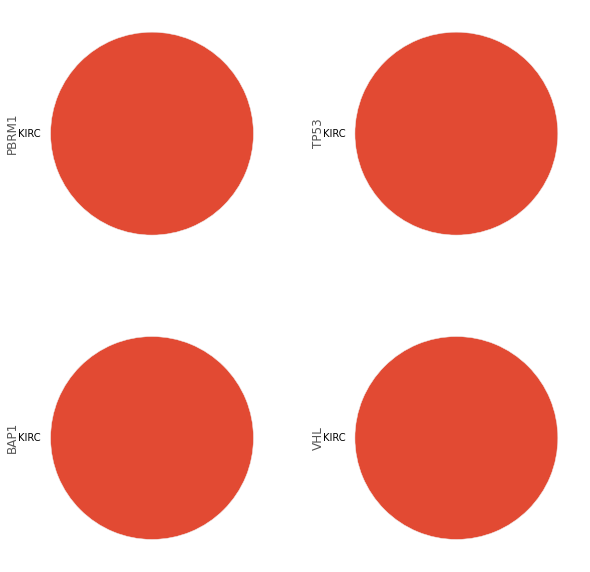

In [160]:
dis_counts = pd.DataFrame({'PBRM1':all_sm[all_sm['Hugo_Symbol'] == 'PBRM1'].groupby('Disease')['Disease'].count(), 
                        'BAP1':all_sm[all_sm['Hugo_Symbol'] == 'BAP1'].groupby('Disease')['Disease'].count(),
                        'TP53':all_sm[all_sm['Hugo_Symbol'] == 'TP53'].groupby('Disease')['Disease'].count(),
                        'VHL':all_sm[all_sm['Hugo_Symbol'] == 'VHL'].groupby('Disease')['Disease'].count(),
                        'BRAF':all_sm[all_sm['Hugo_Symbol'] == 'BRAF'].groupby('Disease')['Disease'].count(),
                        'KRAS':all_sm[all_sm['Hugo_Symbol'] == 'KRAS'].groupby('Disease')['Disease'].count()})

fig, axes = plt.subplots(nrows=2, ncols=2)
dis_counts['PBRM1'].plot(ax=axes[0,0], kind='pie'); axes[0,0]
dis_counts['BAP1'].plot(ax=axes[1,0], kind='pie'); axes[1,0]
dis_counts['TP53'].plot(ax=axes[0,1], kind='pie'); axes[0,1]
dis_counts['VHL'].plot(ax=axes[1,1], kind='pie'); axes[1,1]

fig.savefig('charts/kirc_pie.pdf', bbox_inches='tight', format='pdf')

In [161]:
all_cnv['length'] = all_cnv['End'] - all_cnv['Start']
original_all_cnv = all_cnv.copy()
top_quantile_length = original_all_cnv['length'].quantile(.25) # Higher threshold gives more predictive

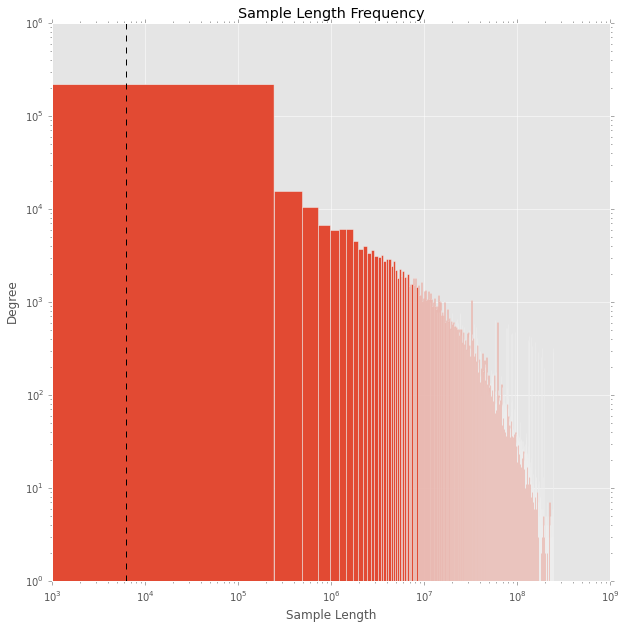

In [162]:
fig, axes = plt.subplots(nrows=1, ncols=1)
original_all_cnv['length'].plot(kind='hist', logy=True, logx=True, bins=1000, ax=axes)
axes.axvline(top_quantile_length, color='k', linestyle='--')
axes.set_xlabel('Sample Length')
axes.set_title('Sample Length Frequency')

fig.savefig('charts/kirc_sample_length_freq.pdf', bbox_inches='tight', format='pdf')
fig.savefig('charts/kirc_sample_length_freq.png', bbox_inches='tight', format='png')
fig.show()

## Filter by Segment Length

In [163]:
print('Top Quantile Length', top_quantile_length)
print('Total Number of samples', len(all_cnv))
all_cnv = all_cnv.loc[all_cnv['length'] > top_quantile_length]
all_cnv = all_cnv.loc[all_cnv['Num_Probes'] >= 10]     # NUM_PROBES CITATION!
print('Number of samples above top quantile', len(all_cnv))
all_cnv.describe()

Top Quantile Length 6318.0
Total Number of samples 449179
Number of samples above top quantile 315988


,Start,End,Num_Probes,Segment_Mean,length
count,3.159880e+05,3.159880e+05,315988.000000,315988.000000,3.159880e+05
mean,6.337878e+07,7.864521e+07,8908.316474,-0.014605,1.526643e+07
std,5.730860e+07,5.969883e+07,16670.625493,0.440317,2.978990e+07
min,5.260000e+02,2.142600e+04,10.000000,-6.771300,6.319000e+03
25%,1.728619e+07,2.983707e+07,79.000000,-0.015600,1.908195e+05
50%,4.648576e+07,6.520694e+07,1869.000000,0.009800,3.261376e+06
75%,1.015982e+08,1.164960e+08,10003.000000,0.060300,1.620822e+07
max,2.491916e+08,2.492244e+08,150107.000000,4.323800,2.445951e+08


In [164]:
## Average segment mean 

In [165]:
disease_box = all_cnv.groupby(['Patient', 'Disease'], axis=0).aggregate(np.mean)

In [166]:
disease_box = disease_box.reset_index().pivot('Patient', 'Disease', 'Segment_Mean').reset_index()
stats = disease_box.describe()
stats

,KIRC
count,417.000000
mean,-0.018808
std,0.046090
min,-0.155983
25%,-0.051566
50%,-0.017548
75%,0.009190
max,0.135307


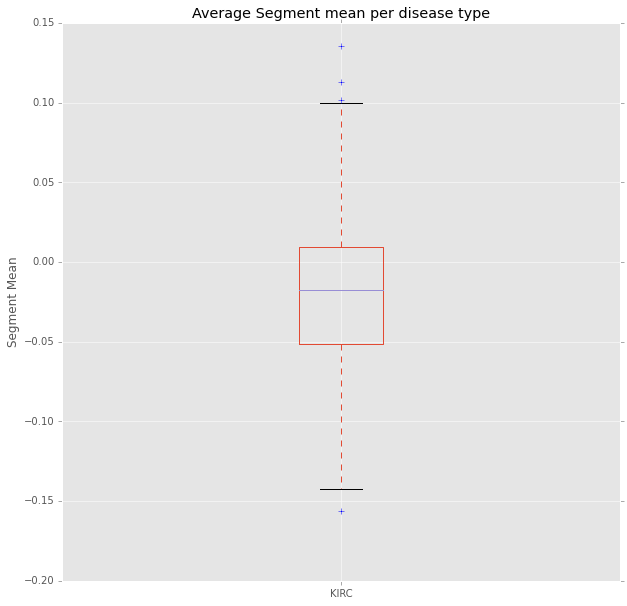

In [167]:
fig, axes = plt.subplots(nrows=1, ncols=1)

disease_box.boxplot(sym='b+', ax=axes)
axes.set_ylabel('Segment Mean')
axes.set_title('Average Segment mean per disease type')
fig.savefig('charts/kirc_disease_box.pdf', bbox_inches='tight', format='pdf')
fig.savefig('charts/kirc_disease_box.png', bbox_inches='tight', format='png')

## Get normalised absolute CNV values

In [168]:
all_cnv['Abs_Segment_Mean'] = abs(all_cnv['Segment_Mean'])
all_cnv['Norm_Abs_Segment_Mean'] = (all_cnv['Abs_Segment_Mean'] - all_cnv['Abs_Segment_Mean'].mean())/(all_cnv['Abs_Segment_Mean'].std())
# all_cnv[['Norm_Abs_Segment_Mean']].plot()


### Select Genes

In [169]:
gene_count = all_sm.groupby('Hugo_Symbol').count().reset_index()
gene_count = gene_count[['Hugo_Symbol', 'Tumor_Sample_Barcode']]
gene_count.columns = ['Gene', 'Count']

gene_list = 'VHL PBRM1 SETD2 BAP1 PTEN RANBP2 PIK3CA ATM AKAP9 TP53'.split(' ')
genes = gene_count[(gene_count['Gene'].isin(gene_list))] # | (gene_length['Gene'].isin(top_genes)) & (gene_length['Gene'] != '.')]

g_count = int(genes[['Gene']].count())
print (g_count)

genes

10


,Gene,Count
285,AKAP9,11
653,ATM,11
759,BAP1,26
5936,PBRM1,79
6185,PIK3CA,11
6640,PTEN,13
6799,RANBP2,11
7360,SETD2,30
8526,TP53,8
8936,VHL,178


## Estimating probability of aneuploidy by mutation 

In [170]:
from scipy.stats import ttest_ind, t

def ttest(control, mut, gene):
    p_value = list(ttest_ind(mut['Norm_Abs_Segment_Mean'], control['Norm_Abs_Segment_Mean']))
    return p_value
    
    

In [171]:
population = all_cnv.groupby('Patient', as_index=False).mean()
t_dict = {}
smm = {}
for gene in genes['Gene']:
    patients = all_sm[all_sm['Hugo_Symbol'] == gene]['Patient'].unique()
    control = population[~population['Patient'].isin(patients)]
    mut = population[population['Patient'].isin(patients)]
    smm[gene] = [mut['Norm_Abs_Segment_Mean'].mean()]
    t_dict[gene] = ttest(control, mut, gene)

In [172]:
gene_ttest = pd.DataFrame(t_dict)
gene_ttest = gene_ttest.transpose().reset_index()
gene_ttest.columns = ['gene', 'sm_t-statistic', 'sm_p-value']
gene_mean = pd.DataFrame(smm)
gene_mean = gene_mean.transpose().reset_index()
gene_mean.columns = ['gene', 'segment_mean']
gene_stats = pd.merge(gene_ttest, gene_mean)
gene_stats = gene_stats.set_index('gene').reset_index()

In [173]:
gene_stats['Corrected_P'] = gene_ttest['sm_p-value']
gene_stats.sort('sm_p-value', ascending=True)

,gene,sm_t-statistic,sm_p-value,segment_mean,Corrected_P
3,PBRM1,1.978038,0.048585,0.016677,0.048585
8,TP53,1.002716,0.316582,0.032377,0.316582
6,RANBP2,-0.875324,0.381904,-0.028993,0.381904
0,AKAP9,0.857139,0.391863,0.022670,0.391863
7,SETD2,0.812768,0.416817,0.011927,0.416817
2,BAP1,0.685512,0.493404,0.010295,0.493404
1,ATM,0.418570,0.675747,0.010352,0.675747
9,VHL,-0.349153,0.727152,-0.003323,0.727152
4,PIK3CA,0.136528,0.891470,0.002237,0.891470
5,PTEN,-0.052342,0.958281,-0.002762,0.958281


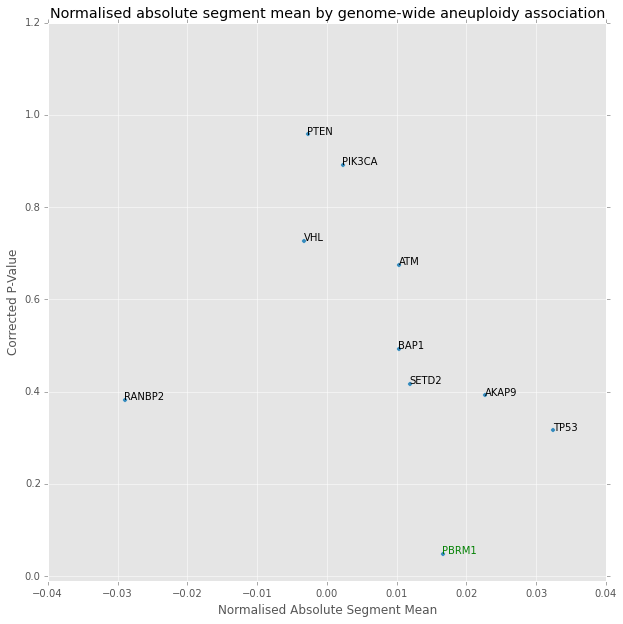

In [174]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if point['y'] > 0.05:
            ax.text(point['x'], point['y'], str(point['val']), color='black')
        else:
            ax.text(point['x'], point['y'], str(point['val']), color='green')

fig, axes = plt.subplots(nrows=1, ncols=1)
gene_stats.plot('segment_mean', 'Corrected_P', ax=axes, kind='scatter')
axes.set_xlabel('Normalised Absolute Segment Mean')
axes.set_ylabel('Corrected P-Value')
axes.set_ylim(-0.01)
axes.set_title('Normalised absolute segment mean by genome-wide aneuploidy association')

label_point(gene_stats.segment_mean, gene_stats.Corrected_P, gene_stats.gene, axes)

fig.savefig('charts/kirc_p-value_scatter.pdf', bbox_inches='tight', format='pdf')
fig.savefig('charts/kirc_p-value_scatter.png', bbox_inches='tight', format='png')

In [175]:
from random import sample
from statistics import mean

def t_test_plot(gene_name, control, mut, samples = 2000, sample_size = 10):
    
    control_sm  = control['Norm_Abs_Segment_Mean']
    mut_sm = mut['Norm_Abs_Segment_Mean']
    control_sm_hist, mut_sm_hist = [], []
    
    i = 0
    while i < samples:
        control_sm_hist.append(mean(sample(list(control_sm), sample_size)) - mean(sample(list(control_sm), sample_size)))
        mut_sm_hist.append(mean(sample(list(mut_sm),sample_size)) - mean(sample(list(control_sm), sample_size)))
#         control_sm_hist.append(mean(sample(list(control_sm), sample_size)))
#         mut_sm_hist.append(mean(sample(list(mut_sm),sample_size)))
        i = i + 1
            
    hists = pd.DataFrame({'csm':control_sm_hist, 'msm':mut_sm_hist})
        
    m_sm = mean(mut_sm) - mean(control_sm)
    
    bins = 100
    fig, axes = plt.subplots(nrows=1, ncols=1)
    
    hists['csm'].plot(ax=axes, bins=bins, kind='hist', alpha=0.3, label='Control'); 
    hists['msm'].plot(ax=axes, bins=bins, kind='hist', alpha=0.3, label='Mutation');
    axes.set_title('%s Sampled Segment Mean' % gene_name);
    axes.axvline(m_sm, color='k', linestyle='--')
    axes.set_xlabel('Normalised Absolute Segment Mean')
    sm_t_vals = 'T-Statistic:\n%s\n\nP-Value:\n%s' % ttest_ind(control_sm, mut_sm)
    fig.text(0.88, 0.8, sm_t_vals, horizontalalignment='right', verticalalignment='top', fontdict=None)
    axes.legend()
    
    fig.savefig('charts/kirc_%s_fig.pdf' % gene_name, bbox_inches='tight', format='pdf')
    fig.savefig('charts/kirc_%s_fig.png' % gene_name, bbox_inches='tight', format='png')

-0.0055848950333
0.0166774706956


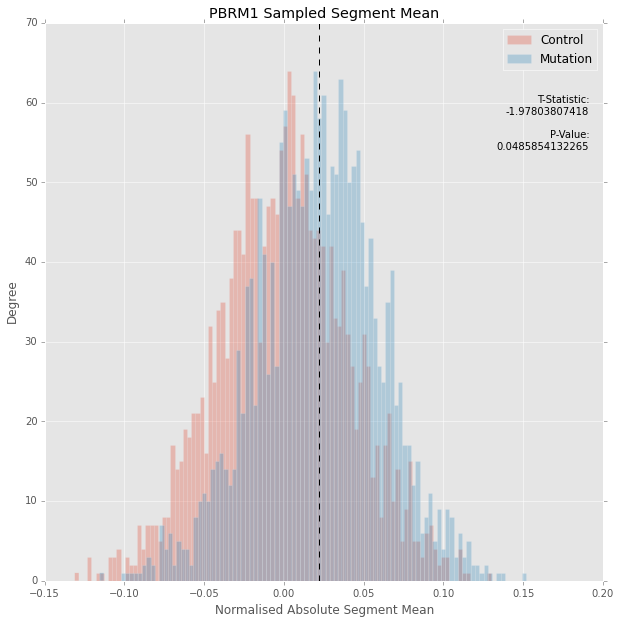

In [176]:
gene_name = 'PBRM1'
patients = all_sm[all_sm['Hugo_Symbol'] == gene_name]['Patient'].unique()
control = population[~population['Patient'].isin(patients)]
mut = population[population['Patient'].isin(patients)]
t_test_plot(gene_name,control,mut)
print(control['Norm_Abs_Segment_Mean'].mean())
print(mut['Norm_Abs_Segment_Mean'].mean())




gene_name = 'TP53'
patients = all_sm[all_sm['Hugo_Symbol'] == gene_name]['Patient'].unique()
control = population[~population['Patient'].isin(patients)]
mut = population[population['Patient'].isin(patients)]
t_test_plot(gene_name,control,mut)
print(control['Norm_Abs_Segment_Mean'].mean())
print(mut['Norm_Abs_Segment_Mean'].mean())

### Segment arm data

In [177]:
centromeres = pd.read_csv(data_dir+'centromeres.txt', sep='\t', names=['chrom', 'start', 'stop', 'arm', 'acen'])
centromeres['chrom'] = centromeres['chrom'].apply(func=lambda x: x.replace('chr',''))

arm_dict = {}
def add_to_centromere_dict(row):
    if 'p' in row['arm']:
        arm_dict[row['chrom']] = row['stop']

def find_arm(row):
    if row['End'] <= arm_dict[row['Chromosome']]:
        return row['Chromosome'] + 'p'
    else:
        return row['Chromosome'] + 'q'

centromeres.apply(add_to_centromere_dict, axis=1)
all_cnv['arm'] = all_cnv.apply(find_arm, axis=1)

arm_names = []
missing_arms = ['13p', '14p', '15p', '22p']
for i in range(1, 23):
    for j in ['p', 'q']:
        arm = str(i)+j
        if arm not in missing_arms:
            arm_names.append(str(i)+j) 

arm_data = all_cnv.groupby(['Patient', 'arm'], axis=0).aggregate(np.mean)
arm_data = arm_data.reset_index().pivot('Patient', 'arm', 'Segment_Mean').reset_index()
arm_data = arm_data[['Patient'] + arm_names]
arm_data = arm_data.fillna(0)
arm_sm = pd.DataFrame(arm_data.mean(), columns=['Average Segment Mean']).transpose()

arm_sm


arm,Patient,1p,1q,2p,2q,3p,3q,4p,4q,5p,5q,6p,6q,7p,7q,8p,8q,9p,9q,10p,10q,11p,11q,12p,12q,13q,14q,15q,16p,16q,17p,17q,18p,18q,19p,19q,20p,20q,21p,21q,22q
Average Segment Mean,inf,-0.023756,-0.029697,-0.036127,0.010217,-0.229597,-0.031551,-0.061774,-0.031358,0.059485,0.120712,-0.025405,-0.07017,0.064417,0.03332,-0.092428,-0.004183,-0.082427,-0.028478,0.006229,-0.01729,-0.008505,-0.010845,-0.007472,0.044919,-0.039956,-0.085069,-0.026995,0.007268,-0.012682,-0.01748,0.061745,0.006729,-0.023523,-0.010492,-0.000988,0.120489,0.012561,-0.020994,0.010725,0.019488


In [178]:
arm_data


arm,Patient,1p,1q,2p,2q,3p,3q,4p,4q,5p,5q,6p,6q,7p,7q,8p,8q,9p,9q,10p,10q,11p,11q,12p,12q,13q,14q,15q,16p,16q,17p,17q,18p,18q,19p,19q,20p,20q,21p,21q,22q
0,3308,0.034186,0.172411,0.085260,-0.005214,-0.147037,-0.020794,0.162209,0.084164,-0.001975,0.075750,0.144247,-0.062062,-0.031770,0.108264,-0.098837,0.412518,-0.034416,0.064682,-0.061795,0.011420,0.173164,0.089271,-0.170246,0.087467,-0.174814,0.038002,0.087184,-0.086490,0.058972,-0.279207,0.181403,0.432508,-0.217940,0.033414,0.006400,-0.158362,0.227096,0.578800,0.020259,0.048818
1,3311,0.069908,-0.012122,-0.156164,-0.001678,-0.520302,-0.121255,0.222308,0.058524,-0.109004,0.091852,0.150076,-0.177654,0.003829,-0.189000,-0.022802,0.072619,-0.072026,-0.051562,0.000976,0.173817,-0.104170,0.117979,-0.069686,0.189973,0.055521,-0.211040,0.033903,-0.136204,0.047861,-0.215981,-0.084496,0.095917,0.023162,0.028000,0.065900,0.336129,0.036543,0.000000,0.075667,0.177500
2,3316,0.012455,0.139878,0.078306,-0.021030,-0.168743,0.015386,0.015925,-0.029318,0.092931,0.384519,-0.140687,-0.075500,0.157000,0.001971,0.198406,0.088956,0.000000,-0.048338,0.121030,-0.123163,-0.003714,-0.107695,-0.138045,-0.017562,0.007300,0.071871,-0.020844,-0.208646,-0.312800,-0.047600,0.077389,0.005300,0.126062,0.000000,-0.035063,0.193520,0.076560,-0.002000,0.026700,0.049607
3,3317,-0.042304,0.039681,0.044502,0.091010,-0.223281,-0.308155,0.074503,0.149473,0.063635,0.110260,-0.107232,-0.160305,0.347915,0.209624,0.065447,0.142639,-0.271029,-0.122956,-0.011485,-0.024409,0.049673,0.047443,0.048533,0.033314,-0.019448,-0.336102,-0.004893,0.227129,-0.070489,0.038507,0.174973,0.153688,0.048272,-0.088600,-0.113692,0.353771,0.021841,0.000000,-0.164766,-0.044224
4,3319,0.066833,-0.007169,0.132118,0.040900,-0.338938,0.003489,0.198780,0.106526,0.122413,-0.004994,-0.321213,-0.270463,-0.035847,0.115218,-0.423894,0.345879,-0.450058,-0.207065,-0.246543,-0.036690,-0.081982,0.031168,-0.043475,0.536853,-0.324777,-0.259540,-0.020824,0.157348,-0.231870,0.024913,0.017247,-0.312926,-0.279758,-0.505408,-0.072773,0.030536,0.429542,0.000000,0.108170,0.109719
5,3320,0.044980,-0.089479,0.038570,-0.017219,-0.301422,-0.004556,-0.036764,-0.145792,-0.055913,0.068871,0.080878,-0.379023,0.052720,0.006676,0.161047,0.142333,-0.002042,0.077963,-0.010625,0.070507,0.070075,-0.032814,-0.028250,0.122774,-0.078826,-0.072755,0.083452,0.137162,-0.030136,0.239420,0.003610,0.024600,0.035116,0.008267,0.006223,-0.237750,0.056167,-0.063000,0.061825,-0.008331
6,3322,0.196272,0.082276,-0.174562,0.104676,-1.035982,-0.457430,0.187469,0.124150,0.392058,0.356402,0.023567,0.036654,0.409220,0.460302,0.072919,-0.019365,-0.033548,0.050385,0.023146,0.078244,0.242145,-0.034238,-0.075957,0.009821,-0.068064,0.094122,-0.060300,0.132659,0.024702,0.121912,-0.018561,0.174567,0.051507,0.066089,0.140313,-0.146909,0.017947,-0.110400,0.412700,0.163427
7,3323,0.092881,-0.123134,0.132000,-0.052148,-0.328400,0.053908,0.116211,0.165400,-0.138310,0.126719,0.156327,0.071590,0.064878,-0.236172,0.083871,0.097457,-0.203138,0.047764,0.050925,0.095894,0.147325,0.069944,-0.125708,0.101704,-0.056154,0.058432,0.225861,0.223285,0.211175,0.265700,0.257088,0.000000,-0.062063,0.082891,0.092430,0.327480,0.014217,0.479600,0.064500,0.140700
8,3326,-0.302360,-0.065081,-0.016856,-0.061718,-0.301450,-0.008573,-0.034000,-0.210441,0.043935,-0.004931,-0.242816,0.013795,-0.024464,-0.006475,-0.169165,0.009550,0.050317,0.010100,0.010850,-0.068638,0.034775,0.021133,-0.029888,0.080406,-0.059500,-0.095625,0.115233,-0.260982,0.071067,-0.463871,0.018440,0.000000,-0.000130,0.020067,-0.063429,0.671320,0.006425,0.000000,0.004680,0.052308
9,3346,0.019507,0.363536,0.086844,-0.062181,-0.268610,-0.199186,-0.104033,-0.153803,0.154308,-0.244350,-0.293592,0.056962,0.172000,-0.038408,-0.055673,0.056057,-0.189241,-0.131533,-0.110820,-0.053150,0.080710,-0.075850,-0.090022,0.123647,-0.117778,-0.238517,0.104917,-0.108789,0.166267,-0.066200,0.029893,-0.291567,-0.119183,0.123483,0.148986,-0.105258,0.087075,-0.279200,0.171125,0.161496


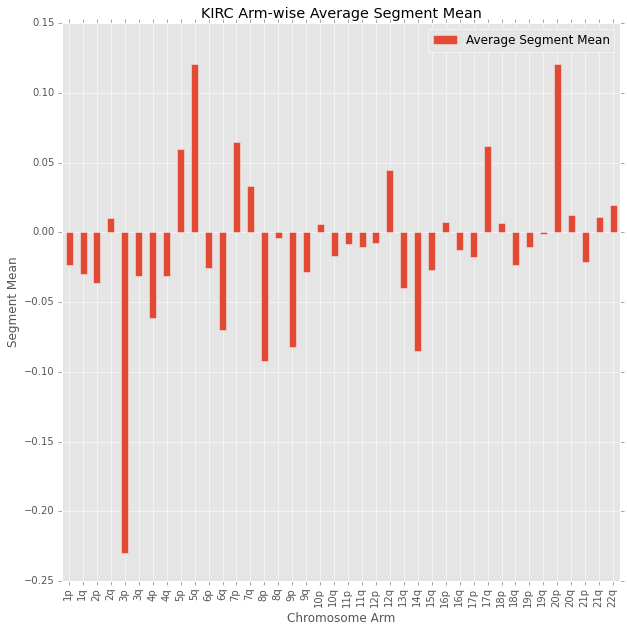

In [179]:
fig, axes = plt.subplots(nrows=1, ncols=1)
arm_sm[arm_names].transpose().plot(kind='bar', label='Segment Mean', ax=axes)
axes.set_title('KIRC Arm-wise Average Segment Mean')
axes.set_ylabel('Segment Mean')
axes.set_xlabel('Chromosome Arm')
fig.savefig('charts/kirc_avg_arm_seg_mean.pdf', bbox_inches='tight', format='pdf')
fig.savefig('charts/kirc_avg_arm_seg_mean.png', bbox_inches='tight', format='png')
fig.show()

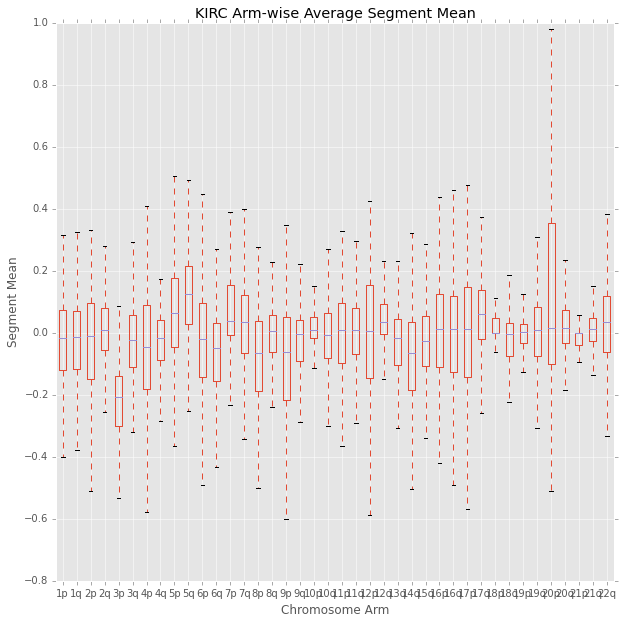

In [180]:
fig, axes = plt.subplots(nrows=1, ncols=1)
arm_data.plot(kind='box', sym='', label='Segment Mean', ax=axes)
axes.set_title('KIRC Arm-wise Average Segment Mean')
axes.set_ylabel('Segment Mean')
axes.set_xlabel('Chromosome Arm')
fig.savefig('charts/kirc_arm_box.pdf', bbox_inches='tight', format='pdf')
fig.savefig('charts/kirc_arm_box.png', bbox_inches='tight', format='png')
fig.show()

## Patients with loss of 3p

In [181]:
total = int(arm_data[['3p']].count())
no3p = int(arm_data[['3p']][arm_data['3p'] < -0.1].count())
print(no3p, '/', total, '=', (no3p/total))

352 / 417 = 0.8441247002398081


In [182]:
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn import linear_model
from sklearn.ensemble import ExtraTreesClassifier

def get_importances(gene_name, X_train, y_train):

    forest = ExtraTreesClassifier(n_estimators=1000, min_samples_leaf=50, random_state=0)
    forest.fit(X_train, y_train)
    importances = forest.feature_importances_
    indices = np.argsort(importances)[::-1]
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    rank = dict(zip(list(X_train.columns), importances))
    # Plot the feature importances of the forest
    plt.figure()
    plt.title("%s feature importances" % gene_name)
    plt.bar(range(len(X_train.columns)), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(len(X_train.columns)), X_train.columns[indices])
    plt.xlim([-1, len(X_train.columns)])
    
    print("%s Feature ranking:" % gene_name)
    for i in range(10):
        feature = X_train.columns[indices[i]]
        print(i+1, '. ', feature, '-',  rank[feature])
        
    return plt

def get_roc(gene_name, y_test, y_score, n_classes):
       

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_score)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    auc_dict[gene_name] = roc_auc[0]
        
    #Plot of a ROC curve for a specific class
    plt.plot(fpr[0], tpr[0], label='ROC curve (area = %0.2f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.fill(fpr[0], tpr[0], 'r', alpha=0.05)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s receiver operating characteristic' % gene_name)
    plt.legend(loc="lower right")
    return plt
        
def analyse_arms(gene = 'PBRM1'):
    import warnings
    warnings.filterwarnings('ignore')
    
    patients = all_sm[all_sm['Hugo_Symbol'] == gene]['Patient'].unique()
    
    arm_data['mutation'] = arm_data['Patient'].isin(patients)
    X = arm_data[arm_names]
    y = arm_data[['mutation']]
    y = label_binarize(y, classes=[0,1])  # Binarize the output
    n_classes = y.shape[1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)
    lm = linear_model.LogisticRegression()
    lm_fit = lm.fit(X_train, y_train)
    y_score = lm_fit.decision_function(X_test)
    
    roc = get_roc(gene, y_test, y_score, n_classes)
    roc.savefig('charts/all_%s_roc.pdf' % gene, bbox_inches='tight', format='pdf')
    roc.savefig('charts/all_%s_roc.png' % gene, bbox_inches='tight', format='png')
    importance = get_importances(gene, X_train, y_train)
    importance.savefig('charts/all_%s_importance.pdf' % gene, bbox_inches='tight', format='pdf')
    importance.savefig('charts/all_%s_importance.png' % gene, bbox_inches='tight', format='png')
    roc.show()
    importance.show()
    

    





In [183]:
# from sklearn import tree
# patients = all_sm[all_sm['Hugo_Symbol'] == 'PBRM1']['Patient'].unique()
# arm_data['mutation'] = arm_data['Patient'].isin(patients)
# X = arm_data[arm_names]
# y = arm_data[['mutation']]
# y = label_binarize(y, classes=[0,1])  # Binarize the output
# n_classes = y.shape[1]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

# clf = tree.DecisionTreeClassifier()
# clf = clf.fit(X_train, y_train)


In [184]:

# from IPython.display import Image  
# dot_data = StringIO()  
# tree.export_graphviz(clf)  
# graph = pydot.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())  


VHL Feature ranking:
1 .  1q - 0.0893800069527
2 .  17p - 0.0401342081439
3 .  16q - 0.0384750215665
4 .  6q - 0.0374595509635
5 .  9q - 0.0362996066497
6 .  7p - 0.0351058517132
7 .  9p - 0.0346956936049
8 .  1p - 0.0306074652589
9 .  8p - 0.0296088444892
10 .  3q - 0.0273781617361


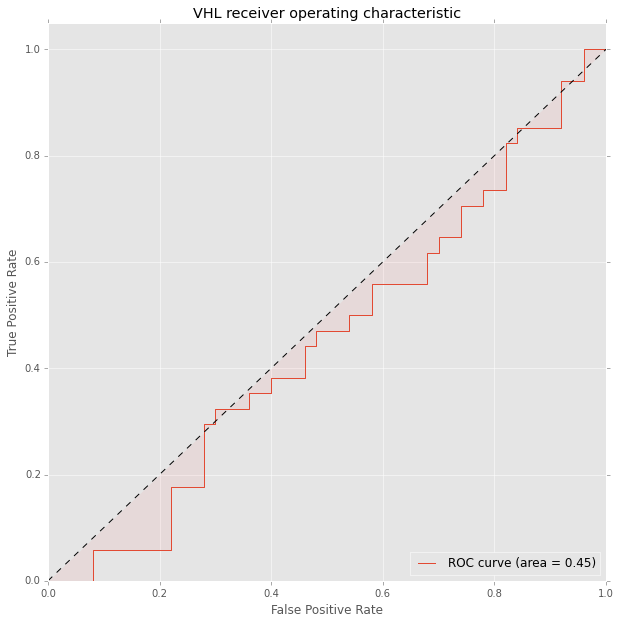

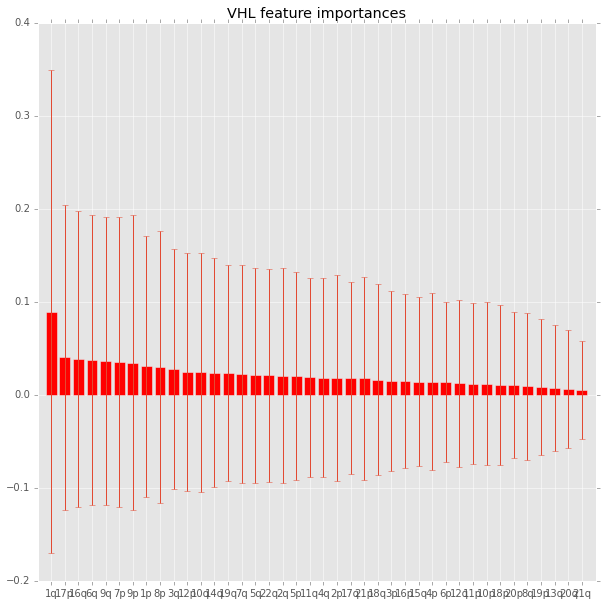

PBRM1 Feature ranking:
1 .  17p - 0.0739440056994
2 .  6q - 0.0533720124685
3 .  12q - 0.0509447039398
4 .  15q - 0.044982922104
5 .  7q - 0.0425808950115
6 .  20p - 0.0401711021351
7 .  9p - 0.036333613734
8 .  10q - 0.0353263259796
9 .  7p - 0.0294026561799
10 .  16p - 0.0279859875886


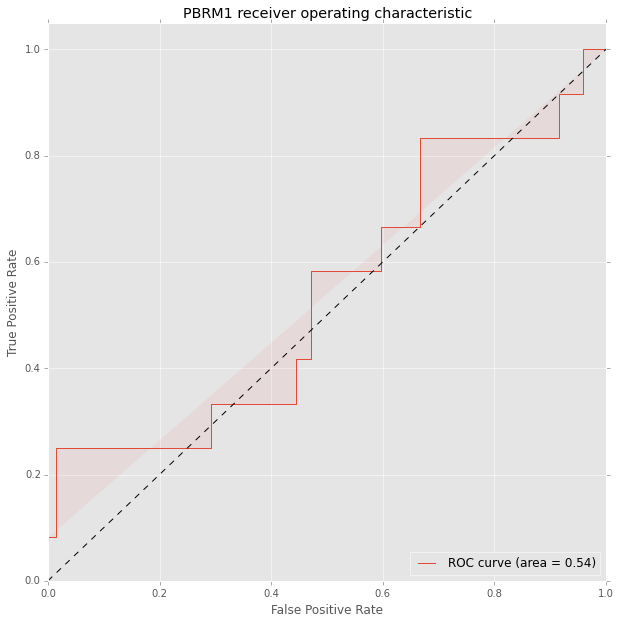

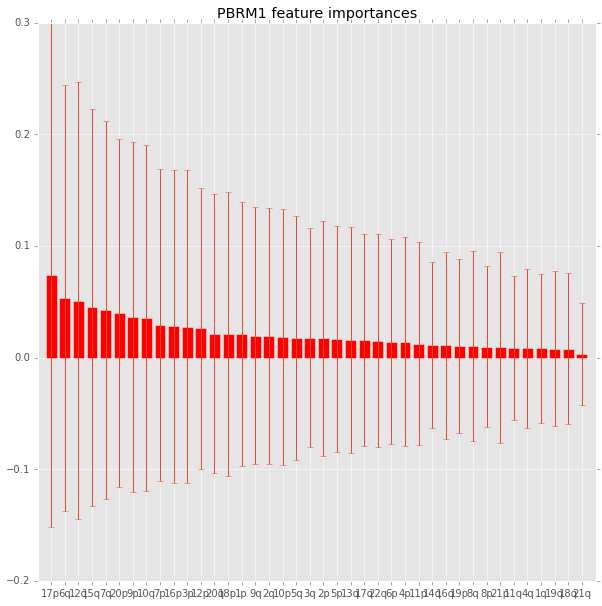

SETD2 Feature ranking:
1 .  4q - 0.0530837515928
2 .  9q - 0.0497895723566
3 .  1p - 0.0488166375844
4 .  17q - 0.0371723479319
5 .  6q - 0.0340635796524
6 .  9p - 0.0333442132327
7 .  20q - 0.029144900527
8 .  4p - 0.0279905607606
9 .  11p - 0.0269220714828
10 .  14q - 0.0257560900581


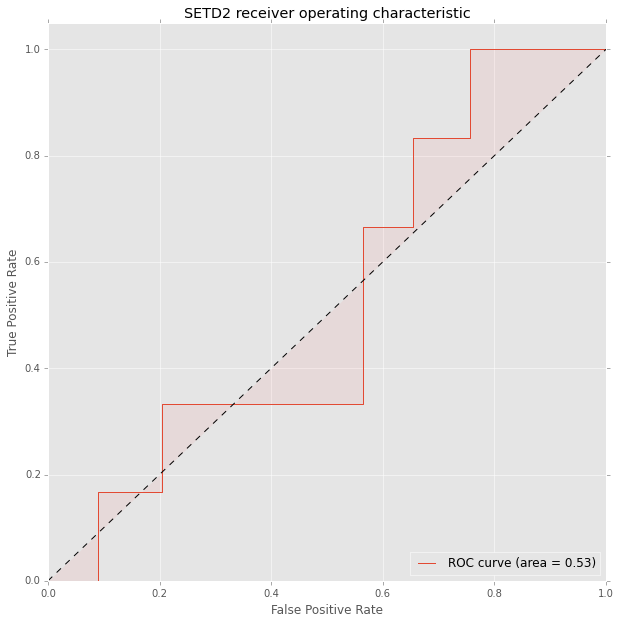

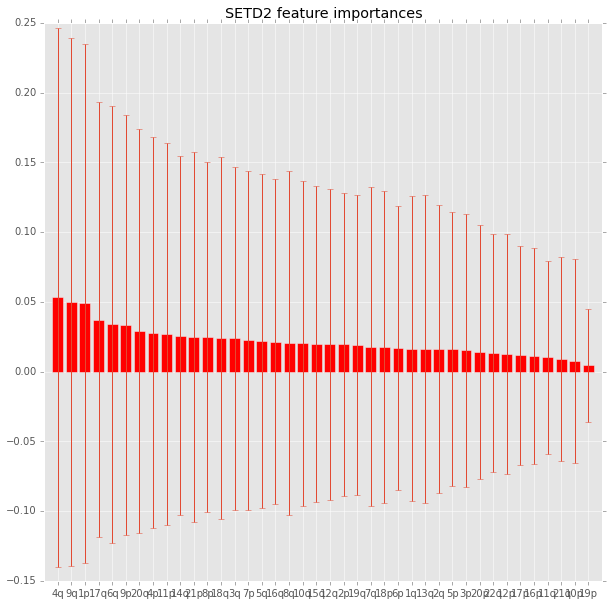

BAP1 Feature ranking:
1 .  16q - 0.0508461205897
2 .  7q - 0.0505276336709
3 .  5q - 0.0448660449612
4 .  4p - 0.0425483224635
5 .  12p - 0.0324134492203
6 .  17p - 0.0321019233091
7 .  20p - 0.0310352759509
8 .  9p - 0.0307244666541
9 .  17q - 0.0290921460757
10 .  8p - 0.0286938514181


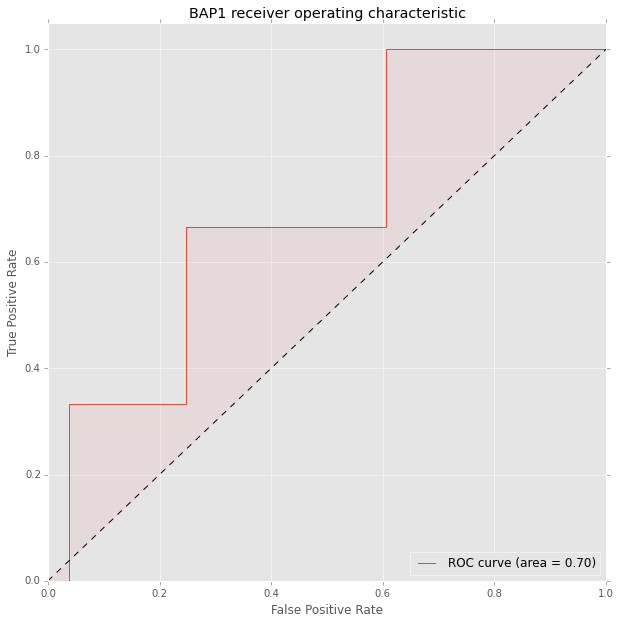

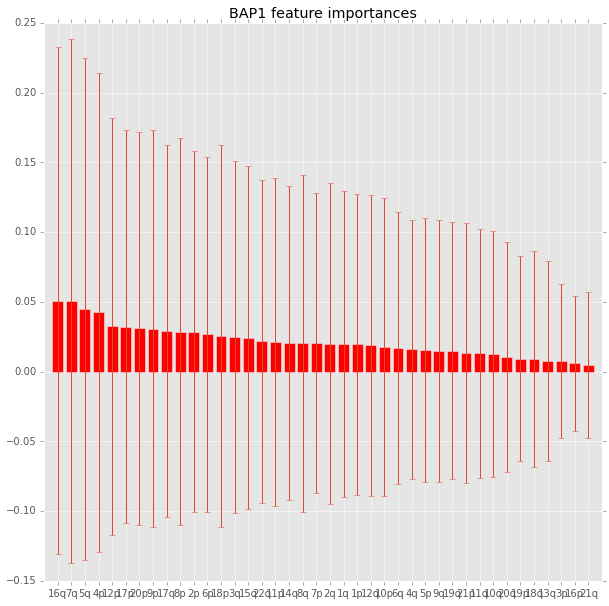

PTEN Feature ranking:
1 .  6q - 0.0474466747473
2 .  12p - 0.047105596763
3 .  10q - 0.0410093131438
4 .  14q - 0.0408291545789
5 .  17p - 0.0372278940151
6 .  16p - 0.0366321509043
7 .  19q - 0.0325001110311
8 .  1q - 0.0314299779401
9 .  5p - 0.0312005898669
10 .  20p - 0.029638186977


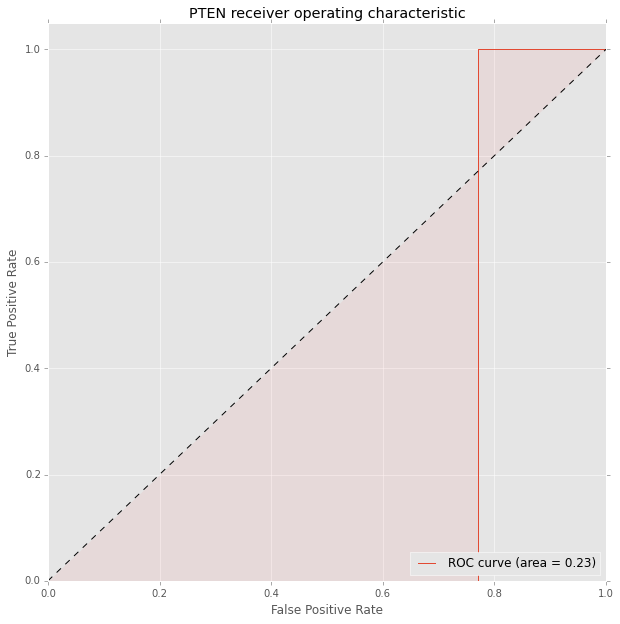

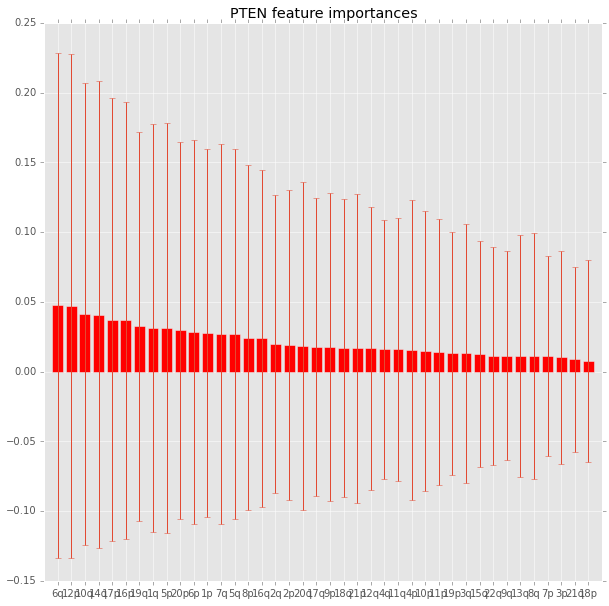

RANBP2 Feature ranking:
1 .  6q - 0.0461236516554
2 .  16q - 0.0454495924552
3 .  10q - 0.0401463308665
4 .  2p - 0.0398032836663
5 .  8p - 0.0382819186938
6 .  12p - 0.0359755271528
7 .  20p - 0.0356634850089
8 .  9p - 0.0341078906032
9 .  3q - 0.0317557142422
10 .  4p - 0.0291876434552


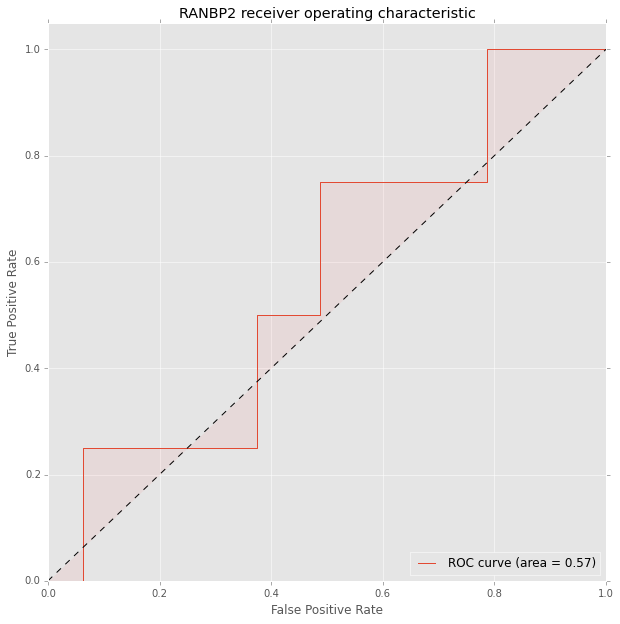

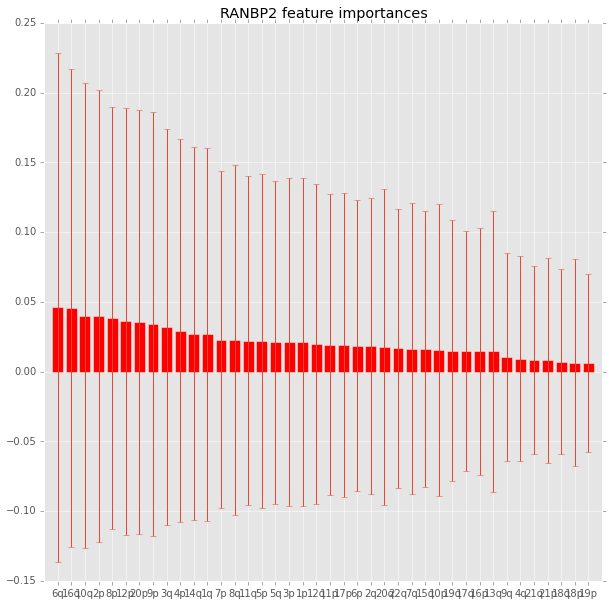

PIK3CA Feature ranking:
1 .  2q - 0.0554547019344
2 .  8p - 0.0444894912155
3 .  1p - 0.0438180186825
4 .  11p - 0.0433819208304
5 .  17q - 0.0374514582699
6 .  4p - 0.0371716751483
7 .  20p - 0.0362976608935
8 .  15q - 0.0319810276722
9 .  16q - 0.0304667649771
10 .  9p - 0.0292979349548


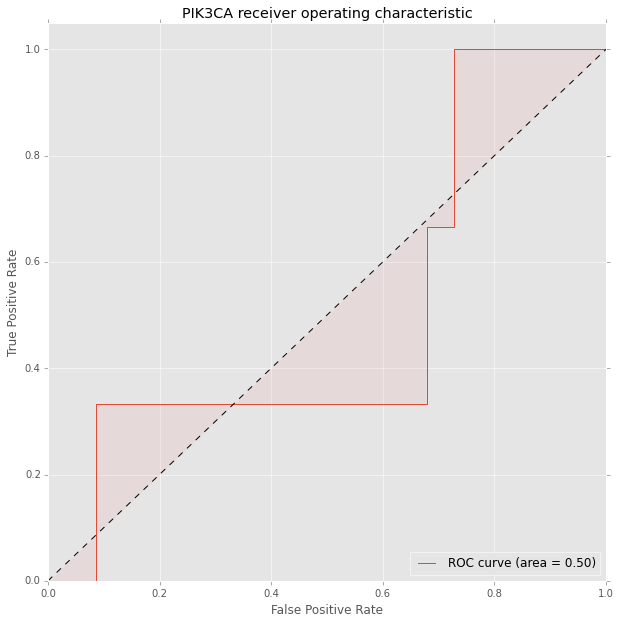

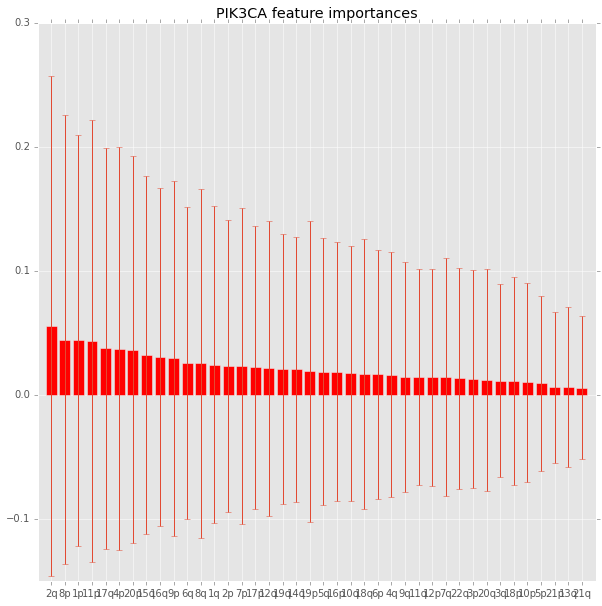

ATM Feature ranking:
1 .  6q - 0.0522707568959
2 .  10q - 0.0455067341389
3 .  22q - 0.0431851469962
4 .  12p - 0.0350840141003
5 .  8p - 0.0346112301393
6 .  5q - 0.0320559401633
7 .  15q - 0.0301525217689
8 .  14q - 0.0300371629856
9 .  5p - 0.0294871923363
10 .  1q - 0.029378158477


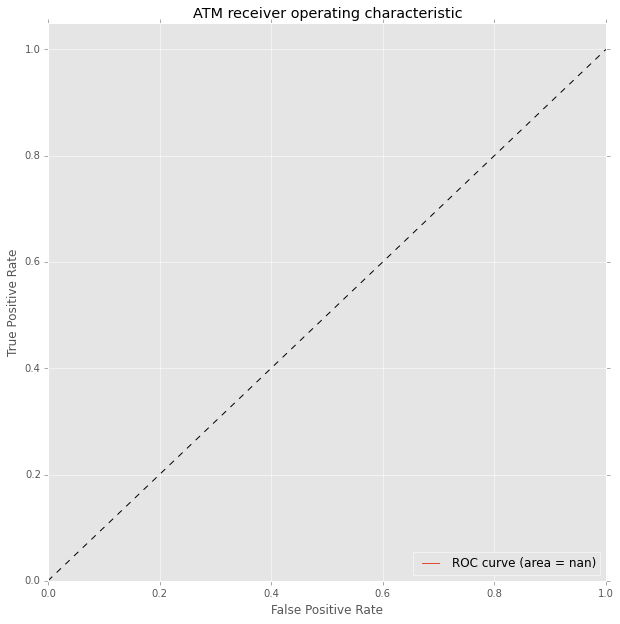

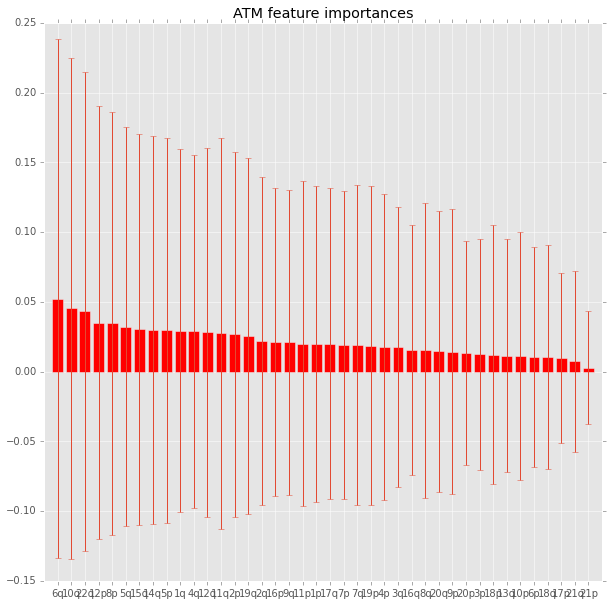

AKAP9 Feature ranking:
1 .  1p - 0.062466045907
2 .  2p - 0.0552777909668
3 .  16q - 0.0498540037905
4 .  7q - 0.0492734597799
5 .  19q - 0.0397100695361
6 .  1q - 0.0349398914101
7 .  18q - 0.0347072503948
8 .  15q - 0.0301435209922
9 .  9p - 0.0299039988253
10 .  9q - 0.0291680304225


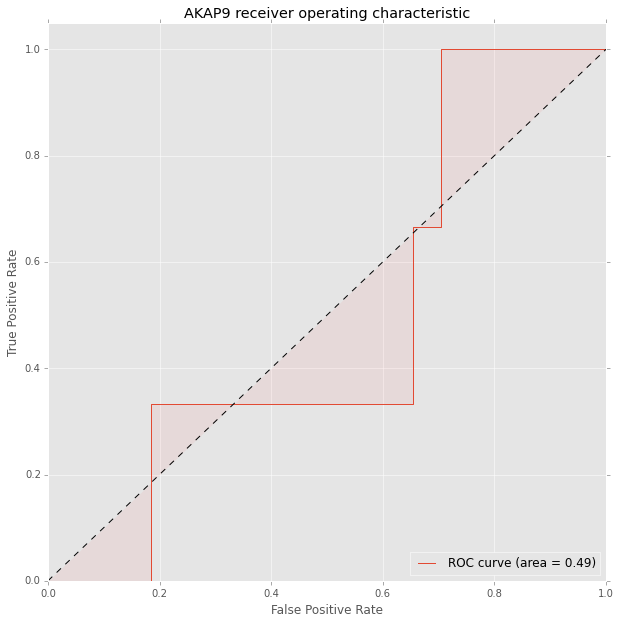

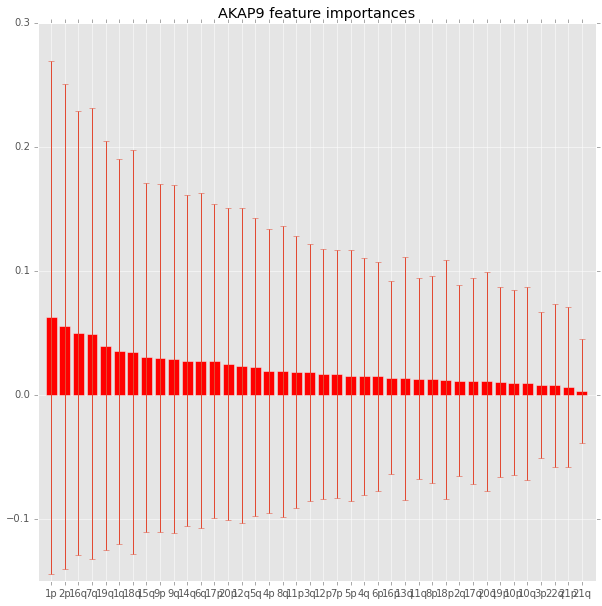

TP53 Feature ranking:
1 .  4p - 0.0567364380338
2 .  8p - 0.0491760279786
3 .  10q - 0.0453130009041
4 .  2q - 0.0386177633764
5 .  6q - 0.0363341786373
6 .  14q - 0.0346860248243
7 .  12p - 0.0337369186331
8 .  11p - 0.0307486693142
9 .  4q - 0.0304502552616
10 .  17p - 0.0293236906224


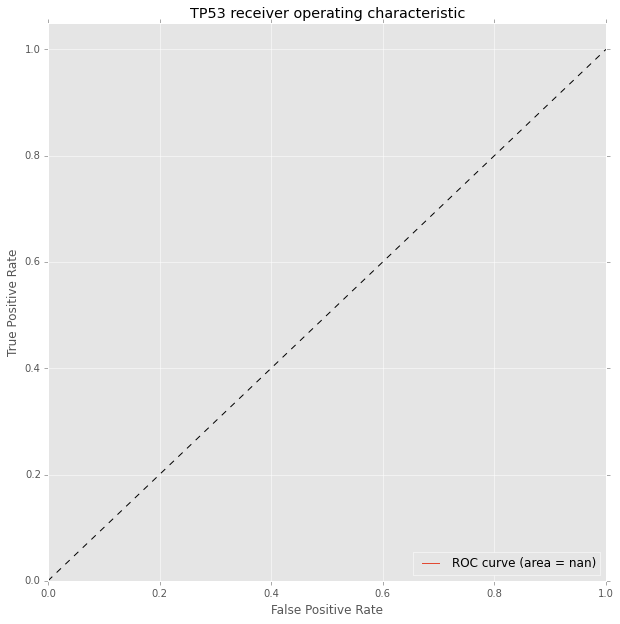

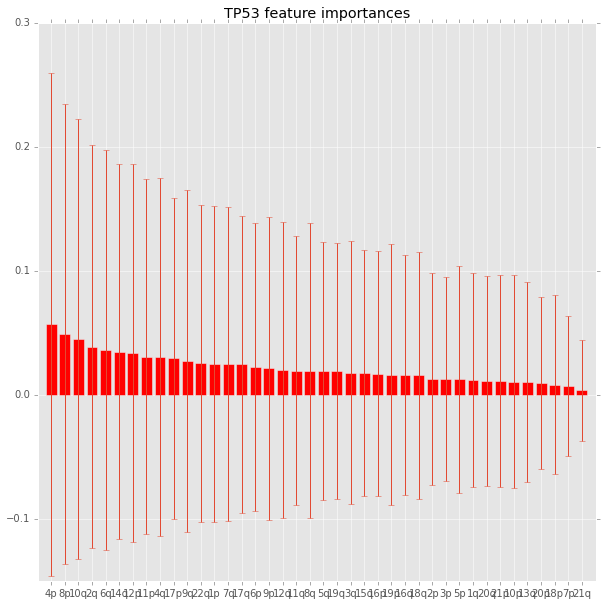

In [185]:
auc_dict = {}

for gene in gene_list:
    try:
        analyse_arms(gene)
    except:
        print(gene, ' failed')

In [186]:
auc_dict

{'AKAP9': 0.48559670781893005,
 'ATM': nan,
 'BAP1': 0.70370370370370372,
 'PBRM1': 0.5405092592592593,
 'PIK3CA': 0.50205761316872421,
 'PTEN': 0.22891566265060237,
 'RANBP2': 0.57187500000000002,
 'SETD2': 0.52777777777777779,
 'TP53': nan,
 'VHL': 0.45235294117647057}

In [187]:
gene_arms_dict = {}

def all_arms(gene = 'PBRM1'):
    import warnings
    warnings.filterwarnings('ignore')
    
    patients = all_sm[all_sm['Hugo_Symbol'] == gene]['Patient'].unique()
    arm_data['mutation'] = arm_data['Patient'].isin(patients)
    X = arm_data[arm_names]
    y = arm_data[['mutation']]
    y = label_binarize(y, classes=[0,1])  # Binarize the output
    n_classes = y.shape[1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                        random_state=0)
    
    forest = ExtraTreesClassifier(n_estimators=1000, min_samples_leaf=50, random_state=0)
    forest.fit(X_train, y_train)
    importances = forest.feature_importances_
    
    gene_arms_dict[gene] = list(importances)        
    
for gene in genes['Gene']:
    all_arms(gene)

In [188]:
######## HACKY CO_mutations #########
gene = 'VHL & PBRM1'
pbr_patients = all_sm[all_sm['Hugo_Symbol'] == 'PBRM1']['Patient'].unique()
vhl_patients = all_sm[all_sm['Hugo_Symbol'] == 'VHL']['Patient'].unique()
patients = [p for p in pbr_patients if p in vhl_patients]
arm_data['mutation'] = arm_data['Patient'].isin(patients)
X = arm_data[arm_names]
y = arm_data[['mutation']]
y = label_binarize(y, classes=[0,1])  # Binarize the output
n_classes = y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=0)

forest = ExtraTreesClassifier(n_estimators=1000, min_samples_leaf=50, random_state=0)
forest.fit(X_train, y_train)
importances = forest.feature_importances_

gene_arms_dict[gene] = list(importances)  

In [189]:
gene_arms = pd.DataFrame(gene_arms_dict).transpose().reset_index()
gene_arms.columns = ['gene'] + list(arm_data.columns[1:-1])

pd.options.display.max_columns = 50
gene_arms.transpose().reset_index()


,index,0,1,2,3,4,5,6,7,8,9,10
0,gene,AKAP9,ATM,BAP1,PBRM1,PIK3CA,PTEN,RANBP2,SETD2,TP53,VHL,VHL & PBRM1
1,1p,0.06246605,0.01986692,0.01945766,0.02095815,0.04381802,0.02755469,0.02103787,0.04881664,0.02507911,0.03060747,0.03092137
2,1q,0.03493989,0.02937816,0.01965711,0.008160955,0.02416355,0.03142998,0.02672072,0.01649791,0.01180057,0.08938001,0.01286443
3,2p,0.05527779,0.02658052,0.02852888,0.01745352,0.02341516,0.01907013,0.03980328,0.01957149,0.01287626,0.01846893,0.0251571
4,2q,0.01138249,0.02180954,0.01987107,0.01943268,0.0554547,0.01972369,0.01831898,0.01617943,0.03861776,0.02060728,0.04685873
5,3p,0.007717805,0.0122722,0.007297141,0.02786414,0.01251404,0.01027078,0.02105901,0.01525015,0.01271289,0.01495236,0.01122258
6,3q,0.01804154,0.01761822,0.02471745,0.01777471,0.0115247,0.01299137,0.03175571,0.02374021,0.01774921,0.02737816,0.01795856
7,4p,0.01907342,0.01766851,0.04254832,0.0143019,0.03717168,0.01577469,0.02918764,0.02799056,0.05673644,0.0141186,0.02251171
8,4q,0.01509446,0.02872542,0.01610824,0.008180227,0.01607986,0.01588907,0.009207471,0.05308375,0.03045026,0.01859505,0.007881769
9,5p,0.01536233,0.02948719,0.0155461,0.01654394,0.009222103,0.03120059,0.02187188,0.01605872,0.01266897,0.01992622,0.01380055


In [190]:
gene_mean_dict = {}

def get_gene_mean(gene = 'PBRM1'):
    import warnings
    warnings.filterwarnings('ignore')
    patients = all_sm[all_sm['Hugo_Symbol'] == gene]['Patient'].unique()
    arm_data['mutation'] = arm_data['Patient'].isin(patients)
#     print (arm_data['mutation'])
#     print(arm_data[arm_data['mutation']==True])
    gene_mean_dict[gene] = list(arm_data[arm_data['mutation']==True][arm_names].apply(mean, axis=0))

for gene in genes['Gene']:
    get_gene_mean(gene)
    


In [191]:
######## HACKY CO_mutations #########
gene = 'VHL & PBRM1'
pbr_patients = all_sm[all_sm['Hugo_Symbol'] == 'PBRM1']['Patient'].unique()
vhl_patients = all_sm[all_sm['Hugo_Symbol'] == 'VHL']['Patient'].unique()
patients = [p for p in pbr_patients if p in vhl_patients]
arm_data['mutation'] = arm_data['Patient'].isin(patients)
gene_mean_dict[gene] = list(arm_data[arm_data['mutation']==True][arm_names].apply(mean, axis=0))
gene_mean_dict[gene]

[-0.0027125301694802656,
 -0.029117498528561103,
 -0.050280205375460699,
 0.021443316730017641,
 -0.26237523065040708,
 -0.033156368988448426,
 -0.059829847823482253,
 -0.02514485491617368,
 0.074759353647454854,
 0.14356670422663947,
 -0.042852168334181477,
 -0.056868547192969174,
 0.096067298404182017,
 0.064816648067289623,
 -0.082661328885633961,
 -0.0012024923260546955,
 -0.017699842103095276,
 0.010613977267400643,
 -0.0043740264291092451,
 0.0046634874842831579,
 0.019631716268551938,
 -0.038717807630850781,
 -0.02273915421889797,
 0.056216418931452128,
 0.0038162475525895696,
 -0.072112041016906075,
 -0.0011884123885502593,
 0.01470701035203607,
 0.010941143116775402,
 0.028795334991397491,
 0.09206486240156958,
 0.011573753787878791,
 -0.0094251873101785476,
 -0.0021393283730158736,
 -0.0030914940834063467,
 0.10592977829206614,
 0.032246129878291639,
 0.010315625000000002,
 0.017651254870129873,
 0.041812483771597402]

In [192]:
gene_mean = pd.DataFrame(gene_mean_dict).transpose().reset_index()
gene_mean.columns = ['gene'] + list(arm_data.columns[1:-1])

pd.options.display.max_columns = 50
gene_mean.transpose().reset_index()


,index,0,1,2,3,4,5,6,7,8,9,10
0,gene,AKAP9,ATM,BAP1,PBRM1,PIK3CA,PTEN,RANBP2,SETD2,TP53,VHL,VHL & PBRM1
1,1p,0.06042004,-0.0410416,-0.03748573,-0.01393456,-0.01697565,-0.04515429,-0.001566016,-0.03836078,-0.03068891,-0.02661791,-0.00271253
2,1q,0.04663408,0.03556471,-0.0543467,-0.03507259,-0.0570976,0.01239343,0.03013148,-0.008259773,-0.05011542,-0.05289648,-0.0291175
3,2p,-0.1269775,-0.04998504,-0.01824378,-0.04423796,-0.09628475,-0.06719702,0.1104345,-0.03801558,-0.08419701,-0.03483125,-0.05028021
4,2q,-0.006556875,0.02628385,0.02290869,0.009593007,-0.05403563,0.008774552,0.05661983,0.0162191,-0.04984113,0.01275752,0.02144332
5,3p,-0.2330716,-0.2007311,-0.237158,-0.26799,-0.2362746,-0.1845936,-0.2134264,-0.2225632,-0.2322405,-0.2259229,-0.2623752
6,3q,-0.03361893,-0.06931951,0.01569605,-0.03960432,-0.02985088,-0.03369788,-0.0531851,-0.04489082,-0.04822056,-0.02355851,-0.03315637
7,4p,-0.0252264,-0.03646408,-0.1277032,-0.05205855,-0.0467472,-0.1090388,0.003485561,-0.07827784,-0.1949063,-0.07251192,-0.05982985
8,4q,-0.05860405,0.00120784,-0.03202856,-0.03048059,-0.01669667,-0.06947961,-0.009068794,-0.07351985,0.01899019,-0.02960456,-0.02514485
9,5p,0.08205847,0.07610015,0.03129768,0.07724156,0.08115162,0.02074613,-0.01992383,0.04463335,0.05020289,0.05025992,0.07475935
